**********************************************************************

Reading --> conn_sample.parq , SampleData: True 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2269436 entries, 0 to 2269435
Data columns (total 3 columns):
 #   Column     Dtype         
---  ------     -----         
 0   ts         datetime64[ns]
 1   id_orig_h  object        
 2   id_resp_p  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 51.9+ MB
None

 different ports to 80: 
                                               count
id_orig_h                           id_resp_p       
192.168.204.45                      443         4865
2001:dbb:c18:202:20c:29ff:fe18:b667 445         4840
192.168.202.110                     443         3973
192.168.202.140                     443         3664
192.168.202.108                     443         3447
...                                              ...
192.168.202.110                     48469          1
                                 

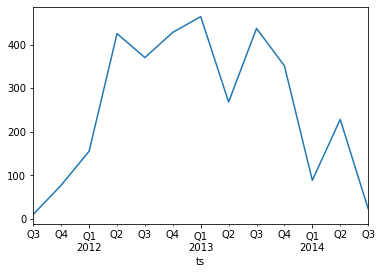


 Exploit Types: ['application/x-java-applet', 'application/pdf', 'application/zip', 'application/jar', 'application/x-shockwave-flash']
Executable Types: ['application/x-dosexec', 'application/octet-stream', 'binary', 'application/vnd.ms-cab-compressed']
                                id_orig_h  id_resp_p  \
ts                                                     
2011-07-22 17:08:11.247202  192.168.95.10         80   
2011-07-22 17:08:14.015447  192.168.95.10         80   
2011-07-22 17:08:23.140325  192.168.95.10         80   
2011-07-22 17:08:49.264341  192.168.95.10         80   
2011-07-22 17:08:49.378921  192.168.95.10         80   
...                                   ...        ...   
2014-07-14 08:44:05.730220  192.168.29.10         80   
2014-07-14 08:44:06.603410  192.168.29.10         80   
2014-07-14 08:44:06.677585  192.168.29.10         80   
2014-07-14 08:44:06.687420  192.168.29.10         80   
2014-07-14 08:44:11.976348  192.168.29.10         80   

               

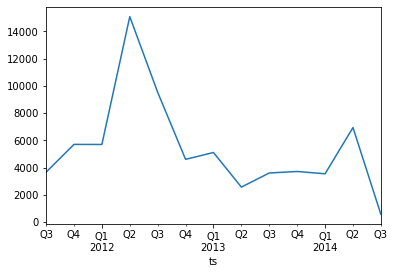


Tiempo del proceso ---> 3.58s


In [1]:
from pandas import DataFrame, read_parquet, read_csv
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np
from pprint import pprint
from time import time
from os import listdir
import sys

def log_to_parquet(in_file: str, out_file: str, file_cols: list, parquet_engine: str):
    # LOAD DATA FROM A LOG FILE AND SAVE IT ON A PARQUET FILE TO IMPROVE PERFORMANCE AT READING THE DATA
    df = read_csv(in_file, sep="\t", header=None,
                  names=file_cols, low_memory=False)
    df.to_parquet(out_file, index=False, engine=parquet_engine)
    del df


def get_files_inFolder(folder: str, fileType: str):
    return list(filter(lambda fileName: 
                            fileName[-len(fileType):] == fileType,
                        listdir(folder)))

#---------------------------------------------------------------------------------------------
def log_analysis(log_file: str, sample_data: bool, table:str):
    list_log_files = get_files_inFolder("./","log")
    list_parq_files = get_files_inFolder("./","parq")
    complete_name_f = log_file.split('.log')[0]+'.parq'
    sample_name_f = log_file.split('.log')[0]+'_sample.parq'
    P_ENGINE = "pyarrow"
    SAMPLE_SIZE = 0.10
    df = None
    if not complete_name_f in list_parq_files:
        if not log_file in list_log_files:
            print("ERROR fileNotFound: "+log_file)
            return 
        try:
            log_col_names = {"conn":['ts', 'uid', 'id_orig_h', 'id_orig_p', 'id_resp_h', 'id_resp_p',
                                     'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes',
                                     'conn_state', 'local_orig', 'missed_bytes', 'history', 'orig_pkts',
                                     'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents'],
                            "http":['ts', 'uid', 'id_orig_h', 'id_orig_p', 'id_resp_h', 'id_resp_p',
                                    'trans_depth', 'method', 'host', 'uri', 'referrer', 'user_agent',
                                    'request_body_len', 'response_body_len', 'status_code', 'status_msg',
                                    'info_code', 'info_msg', 'filename', 'tags', 'username',
                                    'password', 'proxied', 'orig_fuids', 'orig_mime_types', 'resp_fuids',
                                    'resp_mime_types']}
            log_to_parquet(in_file=log_file, out_file=complete_name_f,
                            file_cols=log_col_names[table], parquet_engine=P_ENGINE)
        except Exception as e:
            print(e)
            return
    if sample_data and (not sample_name_f in list_parq_files):
        complete_df = read_parquet(complete_name_f, engine=P_ENGINE)
        # sample_df = get_random_sample_data(complete_df, SAMPLE_SIZE)
        sample_df = complete_df.sample(frac=SAMPLE_SIZE)
        del complete_df
        sample_df.to_parquet(sample_name_f, index=False, engine=P_ENGINE)
        del sample_df

    to_read_file = sample_name_f if sample_data else complete_name_f
    important_cols = {"conn":["ts","id_orig_h", "id_resp_p"],
                    "http":["ts","id_orig_h", "id_resp_p", "resp_mime_types"]}
    print("*"*70)                    
    print("\nReading -->",to_read_file,", SampleData:",sample_data,"\n")
    df = read_parquet(to_read_file, columns=important_cols[table])
    df["ts"] = list(map(
        lambda date: 
            dt.fromtimestamp(float(date)),
        df["ts"].tolist()))
    print(df.info())

    if table == "conn":
        df_gp_not_web_port = df[(df["id_resp_p"] != 80)].groupby(
            important_cols[table][1:3]).size().to_frame()
        df_gp_not_web_port.rename(columns={0: "count"}, inplace=True)
        df_gp_not_web_port.sort_values(by="count", ascending=False, inplace=True)
        print('\n', "different ports to 80: ")
        pprint(df_gp_not_web_port)

    elif table == "http":
        df_not_http = df[~df["id_resp_p"].isin([80,8080])]
        df_not_http.set_index("ts",inplace=True)
        df_not_http = df_not_http.sort_index()
        df_not_http["id_orig_h"].resample('Q').count().plot()
        print('\n', "Different ports to 80 and 8080: ")
        pprint(df_not_http)
        plt.show()

        executable_types = ['application/x-dosexec', 'application/octet-stream',
                            'binary', 'application/vnd.ms-cab-compressed']
        exploit_types = ['application/x-java-applet', 'application/pdf',
                         'application/zip', 'application/jar', 'application/x-shockwave-flash']
        df_exec_exploit = df[df["resp_mime_types"].isin(executable_types+exploit_types)]
        df_exec_exploit.set_index("ts",inplace=True)
        df_exec_exploit = df_exec_exploit.sort_index()
        df_exec_exploit["id_orig_h"].resample('Q').count().plot()
        print('\n', "Exploit Types:",exploit_types)
        print("Executable Types:",executable_types)
        pprint(df_exec_exploit)
        plt.show()

def main():
    paths = {
        "conn":"conn.log",
        "http":"http.log"
    }

    intiTime = time()

    # log_analysis(log_file="conn.log", sample_data=False)
    log_analysis(log_file=paths["conn"], sample_data=True, table="conn")

    log_analysis(log_file=paths["http"],sample_data=False, table="http")

    elapsedTime = round(time()-intiTime, 2)
    elapsedTime = str(elapsedTime/60) + \
        "m" if elapsedTime >= 60 else str(elapsedTime)+"s"
    print("\nTiempo del proceso --->", elapsedTime)


main()
